# Deep learning with Tensorflow - Lab exercise
The purpose of this lab is to give a short demonstration of how to fit CNNs to image data. The example was constructed for this demonstration and is not realistic in some aspects. This has the purpose that the model fitting converges in a reasonable amount of time to be feasible for this lab. The example is further limited through the computational resources that are provided in Google Colab. While the content of the example may not be completely realistic, the procedure would be identical for a realistic application. 

The images that we are using were derived from whole-slide-images (WSIs) of resected prostate tumors that are publicily available through The Cancer Genome Archive (TCGA). Each WSI in the TCGA PRAD (prostate adenoma and adenocarcinoma) dataset was split into smaller image patches. Using a cancer detection CNN, we then selected image patches that likely contain malignant cells. 

The task that we focus on here is the classification of image patches of prostate cancer into "low" and "high" grade. The low grade class is constructed from image patches of patient with a cancer with ISUP grade 1 whereas the high grade image patches originate from patients with ISUP grade 5. 

## 1. Imports, convenience functions and preparation of dataset
In the following section, we will first import the packages that we need for the further code. Then, we will define some convenience functions for plotting results and download and unzip the dataset.

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image_dataset_from_directory

Now that we imported the appropriate packages, we define two convenience functions to plot results. `plot_history` will show the learning curves of the model fitting process. `plot_roc` will show the receiver operating characteristic of the predictions on the test set. 

In [2]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(dpi=150)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

The following code section will first download the dataset that we prepared for this task and then unzip it. The download process has a progress bar, but the unzipping unfortunately does not, so please be patient for a while after the download finished. The total time of the next cell should not be more than 5 minutes. 

In [3]:
!wget --load-cookies /tmp/data_lab.zip "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/data_lab.zip --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1" -O data_lab.zip && rm -rf /tmp/data_lab.zip

print('Unzipping folder... this may take a few minutes without output. Be patient.')
with zipfile.ZipFile('data_lab.zip', 'r') as zip_ref:
    zip_ref.extractall('data_lab')

path_data = '/content/data_lab/data_lab'
train_dir = os.path.join(path_data, 'train')
validation_dir = os.path.join(path_data, 'valid')
test_dir = os.path.join(path_data, 'test')
print('Directories in unzipped folder:', os.listdir(path_data))

--2020-11-17 17:07:02--  https://docs.google.com/uc?export=download&confirm=auHP&id=1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1
Resolving docs.google.com (docs.google.com)... 74.125.142.102, 74.125.142.138, 74.125.142.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-40-docs.googleusercontent.com/docs/securesc/fvb2u1d0mld4ua6go8nc9tnlp8jr808b/eub255uu7ipi5b5uqbrhjpl24ot1rb4c/1605632775000/13525664275705142765/14164671783910603102Z/1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1?e=download [following]
--2020-11-17 17:07:02--  https://doc-08-40-docs.googleusercontent.com/docs/securesc/fvb2u1d0mld4ua6go8nc9tnlp8jr808b/eub255uu7ipi5b5uqbrhjpl24ot1rb4c/1605632775000/13525664275705142765/14164671783910603102Z/1xQEYahKo2RQIo8MW9MVHh7EPru8YFuV1?e=download
Resolving doc-08-40-docs.googleusercontent.com (doc-08-40-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting

## 2. Dataset definition and data augmentation
In this section, we will define a training, validation and test dataset and show an example of data augmentation. There are many different ways in tensorflow to set up data sets. In this case, a dataset is initialised through providing a path to a directory that contains a folder named "low" and one named "high" that contain images of the respective classes. We already split all image patches into training, validation and test folder, so we do not need to sample different folds at this point. 

In [4]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(598, 598))
class_names = train_dataset.class_names

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(598, 598))

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=32,
                                            image_size=(598, 598))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 10927 files belonging to 2 classes.
Found 3678 files belonging to 2 classes.
Found 3660 files belonging to 2 classes.


Now that we defined our datasets, we would like to visually confirm that everything is in order. To this end, we will plot the first 9 images of the first batch with their respective labels. Note that the labels "high" and "low" were assigned to the entire tumor. However, high-grade tumors can sometimes contain some lower grade regions. Unfortunately, we only have the grade on a patient level, so the "high" grade class display a few low-grade examples as well. While this is not ideal to fit CNNs, the CNN will still be able to learn to classify most images correctly but this gives an upper bound to the highest performance that we can expect the model to achieve. You can run the next cell multiple times to see a larger variety of images. 

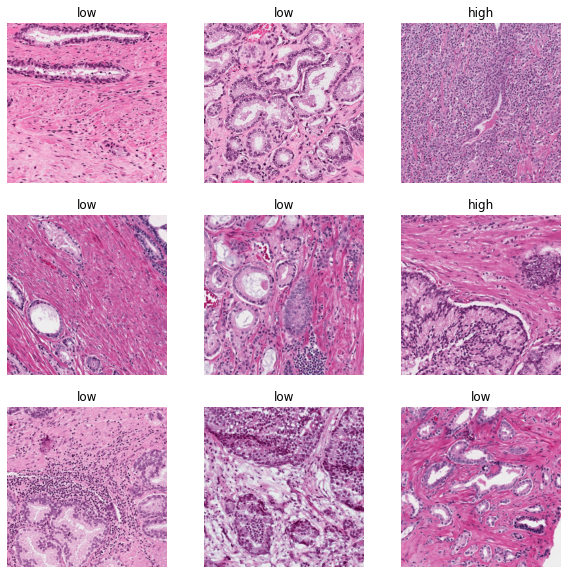

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

A common trick to increase the number of different images that a CNN is trained with is to use data augmentation. In this case, we will randomly mirror and rotate the image patches. Since the filters that a CNN learns are not rotation-invariant, rotated and mirrored image patches will seem like "new" images to the model to a certain extent. Note that rotating images only is appropriate if the images are in fact rotation-invariant. If the rotation of the image matters to the meaning of the image, e.g. when showing a skyline of buildings, it may depend on the specific circumstances whether it is a good idea to rotate them. However, for histopathology images, the rotation at which one examines a glass slide should not matter. Therefore, it is a good idea to use this type of data augmentation here. 

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Now that we have defined our data augmentation functions, let's take a look at what they do to an image. 

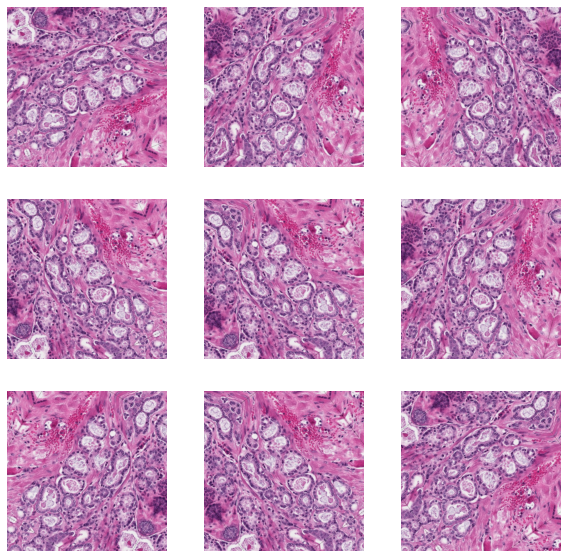

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 3. Model definition
In this section, we will define the model that we would like to fit. We will deploy transfer learning, as was described in the lecture. We will therefore define MibileNetV2 with ImageNet weights as the base model and add a couple of necessary layers to it. Specifically, we add a pooling layer to reduce the final feature maps to a vector, a drop-out layer to reduce overfitting and a fully connected (in tensorflow referred to as "dense") layer with a sigmoid activation function to receive an output that can be interpreted as a probability (although it amy not be well calibrated). 

In [8]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(598, 598, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

inputs = tf.keras.Input(shape=(598, 598, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

9412608/9406464 [==============================] - 0s 0us/step


In this example, we would like to only fit the last 20% of model layers to our images whereas the lower layers of the model will remain fixed. This reduces overfitting since we are fitting fewer parameters to our data. We can assume that the lower layers of the model contain more general image features that are also applicable to histopathology features, so fitting them further to our data may have limited benefit. However, the larger the training data set, the more parameters can be fitted and if we were working with a very large dataset here, we may want to tune the percentage of layers that are fitted as a hyperparameter. 

In [9]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune only last 20% of layers
fine_tune_at = int(0.8*len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


Now we need to define a learning rate, a loss function and an optimizer and then compile the model before training. We choose a very low value for the learning rate, which is typical in transfer learning. The learning rate scales how much the gradient of the difference between prediction and loss changes the model weights. Since our weights are probably already a good starting point from their ImageNet training, we do not want to change them strongly throughout model fitting. 

In [10]:
learning_rate = 0.000001

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 598, 598, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 598, 598, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 598, 598, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 598, 598, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 19, 19, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

## 4. Model fitting
Now we are all set to fit the model to our training data. Since this problem is constructed to be very easy, we will only use 25 batches per epoch to fit the model, which is unrealistically small for a real-world application. To get a more reliable estimate of the model performance, we will evaluate on 50 batches. Typically, the number of validation steps is chosen to be a lot smaller than the number of training steps to not use too much computation time on validation. 

In [11]:
history = model.fit(train_dataset,
                    steps_per_epoch=25, 
                    validation_steps=50,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
25/25 [==============================] - 28s 1s/step - loss: 0.7484 - accuracy: 0.5213 - val_loss: 0.6839 - val_accuracy: 0.5519
Epoch 2/20
25/25 [==============================] - 27s 1s/step - loss: 0.6879 - accuracy: 0.5525 - val_loss: 0.6623 - val_accuracy: 0.6169
Epoch 3/20
25/25 [==============================] - 27s 1s/step - loss: 0.6686 - accuracy: 0.5800 - val_loss: 0.6472 - val_accuracy: 0.6444
Epoch 4/20
25/25 [==============================] - 27s 1s/step - loss: 0.6768 - accuracy: 0.5700 - val_loss: 0.6285 - val_accuracy: 0.6731
Epoch 5/20
25/25 [==============================] - 27s 1s/step - loss: 0.6546 - accuracy: 0.6488 - val_loss: 0.6220 - val_accuracy: 0.6731
Epoch 6/20
25/25 [==============================] - 27s 1s/step - loss: 0.6251 - accuracy: 0.6725 - val_loss: 0.6070 - val_accuracy: 0.6925
Epoch 7/20
25/25 [==============================] - 27s 1s/step - loss: 0.6309 - accuracy: 0.6500 - val_loss: 0.5951 - val_accuracy: 0.7088
Epoch 8/20
25/25 [==

## 5. Visualisation of results
Now that we fitted a model, we would like to inspect the learning curves on the training and validation data. For this relatively easy task, they should be quite similar. However, for more difficult tasks and small datasets, the learning curves could of course exhibit a typical pattern for over- or underfitting. The validation accuracy may actually be higher than the training accuracy throughout the model fitting here due to drop-out, which is active during model fitting but not validation. 

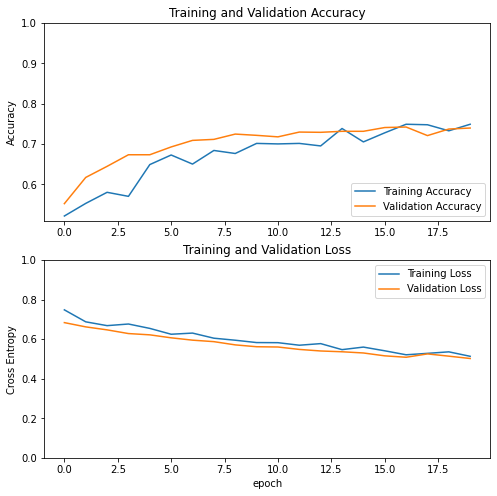

In [12]:
plot_history(history)

Since the learning rates appear reasonably plausible, we will would like to predict the class of a couple of tiles from the test set and compare with their true label. 

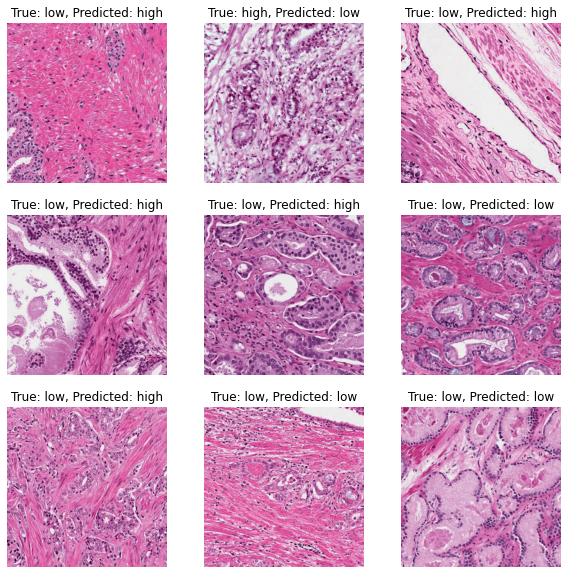

In [13]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('True: {}, Predicted: {}'.format(class_names[predictions[i]], class_names[label_batch[i]]))
  plt.axis("off")

Finally, let's take a look at the ROC of the model that we fitted. For this, we will predict all approx. 120 test set batches, which will take 1-2 minutes. 

115it [00:57,  1.98it/s]


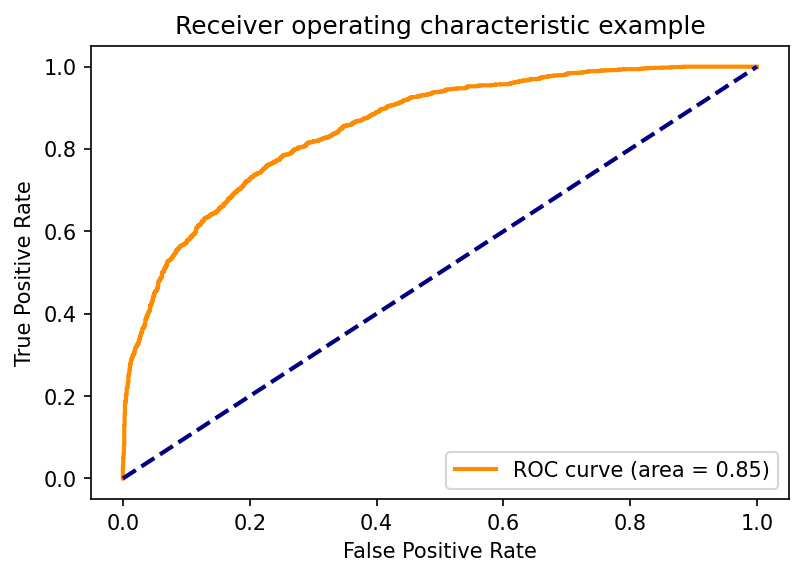

In [14]:
predictions = list()
labels = list()
for image_batch, label_batch in tqdm(test_dataset.as_numpy_iterator()):
    predictions_batch = model.predict_on_batch(image_batch).flatten()
    predictions.append(predictions_batch)
    labels.append(label_batch)
y_score = np.concatenate(predictions)
y_test = np.concatenate(labels)

plot_roc(y_test, y_score)

And we are done! This is everything you that you need to do to fit a CNN to some image data! If you would like to play around with this example, e.g. see what happens when you change the learning rate or set `weights=None` so that the MobileNetV2 was not pretrained on ImageNet, you need to restart this notebook and download and unzip the data again since unfortunately, there is no easy way to release the memory that the model currently uses. 